<a href="https://colab.research.google.com/github/Narasimhag/FunWithTensorFlow/blob/master/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet
ResNets or Residual Networks are first introduced in the paper [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385). Typically, Deep Neural Nets are difficult to train. This paper, presents a residual learning framework to ease the training of networks that are substantially deeper than those used previously (like VGGNet, GoogleNet). 

ResNet has residual blocks which are essentially two dense layers with 'skip connections'. An image from the paper explaning it is shown below, the image of a residual block.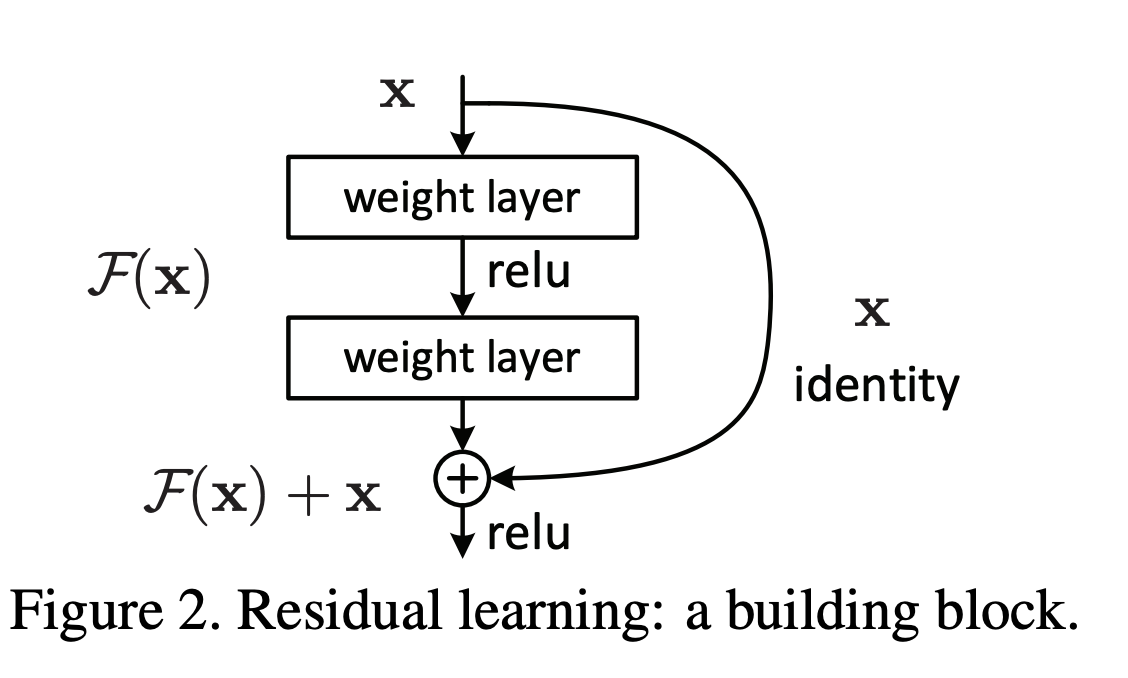


Residual blocks are typically used with convolutional neural networks (CNNs). This allows very deep neural networks of CNNs to be created.

## DataSet
I am training a ResNet on the [CIFAR 10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. The CIFAR-10 and CIFAR-100 are labeled subsets of the 80 million tiny images dataset. They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. The CIFAR-10 data set contains low-res images that are divided into 10 classes. The CIFAR-100 data set contains 100 classes in a hierarchy. For this notebook, I'm using CIFAR 10. And the cool thing with TensorFlow is we have it already in datasets.

Nothing fancy here, just forcing colab to use TensorFlow v2.0

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [0]:
from __future__ import print_function
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.layers import Conv2D, Dense
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import Flatten, AveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import cifar10
import os

#Load Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Visualizing the imported CIFAR 10 data. The following code gets the training data and shows a 10 x 10 sample grid.

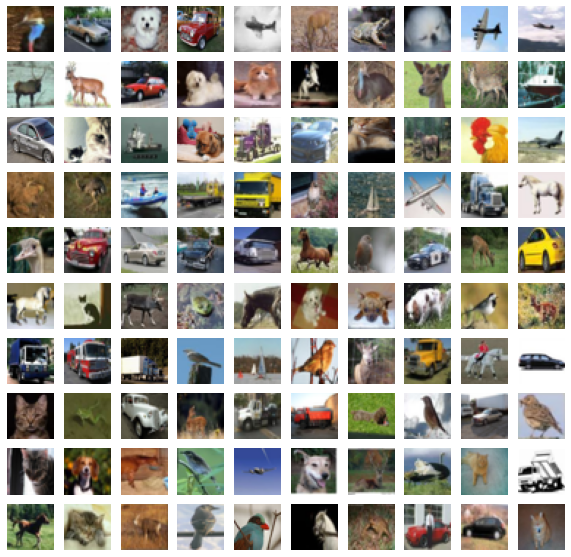

In [37]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from six.moves import cPickle #as the data is in pickle

ROWS = 10

x = x_train.astype('uint8')

pic, axs = plt.subplots(ROWS,ROWS,figsize=(10,10))
for i in range(ROWS):
  for j in range(ROWS):
    k = np.random.choice(range(len(x)))
    axs[i][j].set_axis_off()
    axs[i][j].imshow(x[k:k+1][0])


The objective here is to train ResNet on the above data. I'll define the following training parameters for the network to train on.



1.   BATCH_SIZE - The size of each data batch
2.   EPOCHS - Number of times the network runs through data.
3. NUM_CLASSES - number of classes in the data, in our case 10.
4. COLORS - Color scale of the input images, here 3 (R, G, B).
3.   USE_AUGMENTATION - Data Augmentation is a technique that can be used to artificially expand the size 
of a training dataset by creating modified versions of images in the dataset.
Here I'm setting it to be true. More can be found [here](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/). 
4.   SUBTRACT_PIXEL_MEAN - to center all pixels around 0, helping improve accuracy.
5. DEPTH - Calculate depth from the given parameters.




In [0]:
#TRAINING PARAMETERS
BATCH_SIZE = 32 #Although the paper uses a size of 128, to make sure it fits the colab's GPU
EPOCHS = 200
NUM_CLASSES = np.unique(y_train).shape[0] # 10
COLORS = x_train.shape[3]
USE_AUGMENTATION = True 
# Subtracting pixel mean improves accuracy
SUBTRACT_PIXEL_MEAN = True
# Computed depth from supplied model parameter n
DEPTH = COLORS * 6 + 2 

The learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated. Choosing the learning rate is challenging as a value too small may result in a long training process that could get stuck, whereas a value too large may result in learning a sub-optimal set of weights too fast or an unstable training process. 

That's why I define a function here that updates the learning rate decay schedule. Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs. It is called automatically every epoch as part of callbacks during training.


In [0]:
def lr_schedule(epoch):
  lr = 1e-3
  if epoch > 180:
    lr *= 0.5e-3
  elif epoch > 160:
    lr *= 1e-3
  elif epoch > 120:
    lr *= 1e-2
  elif epoch > 80:
    lr *= 1e-1
  print("learning rate - ", lr)
  return lr

The following code implements a resnet residual block. As stated above a resnet block contains two convolutional layers with skip connection, as shown in the picture above.

In [0]:
def resnet_block(inputs, num_filters=16, kernel_size=3, strides=1, activation='relu', batch_normalization=True, conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """

    conv = Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer='he_normal'
                  , kernel_regularizer=l2(1e-4))
    
    x = inputs
    if conv_first:
      x = conv(x)
      if batch_normalization:
        x = BatchNormalization()(x)
      else:
        x = Activation(activation)(x)
    else:
      if batch_normalization:
        x = BatchNormalization()(x)
      else:
        x = Activation(activation)(x)
      x = conv(x)
    return x

In [0]:
def resnet(input_shape, depth, num_classes = 10):
  
  """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature 
    map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of 
    filters is
    doubled. Within each stage, the layers have the same number 
    filters and the same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
  if (depth - 2) % 6 != 0:
      raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
  # Start model definition.
  num_filters = 16
  num_res_blocks = int((depth - 2) / 6)

  inputs = Input(shape=input_shape)
  x = resnet_block(inputs=inputs)
  # Instantiate the stack of residual units
  for stack in range(3):
      for res_block in range(num_res_blocks):
          strides = 1
          # first layer but not first stack
          if stack > 0 and res_block == 0:  
              strides = 2  # downsample
          y = resnet_block(inputs=x,
                            num_filters=num_filters,
                            strides=strides)
          y = resnet_block(inputs=y,
                            num_filters=num_filters,
                            activation=None)
          # first layer but not first stack
          if stack > 0 and res_block == 0:  
              # linear projection residual shortcut connection to match
              # changed dims
              x = resnet_block(inputs=x,
                                num_filters=num_filters,
                                kernel_size=1,
                                strides=strides,
                                activation=None,
                                batch_normalization=False)
          x = tensorflow.keras.layers.add([x, y])
          x = Activation('relu')(x)
      num_filters *= 2

  # Add classifier on top.
  # v1 does not use BN after last shortcut connection-ReLU
  x = AveragePooling2D(pool_size=8)(x)
  y = Flatten()(x)
  outputs = Dense(num_classes,
                  activation='softmax',
                  kernel_initializer='he_normal')(y)

  # Instantiate model.
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

In [46]:
# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if SUBTRACT_PIXEL_MEAN:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = tensorflow.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = tensorflow.keras.utils.to_categorical(y_test, NUM_CLASSES)

# Create the neural network
model = resnet(input_shape=input_shape, depth=DEPTH)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 10, 10)
learning rate -  0.001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_126 (Conv2D)             (None, 32, 32, 16)   448         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_114 (BatchN (None, 32, 32, 16)   64          conv2d_126[0][0]                 
__________________________________________________________________________________________________
conv2d_127 (Conv2D)             (None, 32, 32, 16)   2320        b

In [49]:
import time

start_time = time.time()

# Prepare callbacks for model saving and for learning rate adjustment.
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not USE_AUGMENTATION:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation 
        # (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, 
                        batch_size=BATCH_SIZE),
                        validation_data=(x_test, y_test),
                        epochs=EPOCHS, verbose=0, workers=1,
                        callbacks=callbacks, 
                        use_multiprocessing=False)
    
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Using real-time data augmentation.
learning rate -  0.001


ValueError: ignored

In [0]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])